# Popular Areas in NYC

This notebook contains exploratory data analysis of **New York Citibike** dataset. <br/>
The dataset is used as proxy to determine most popular New York areas.

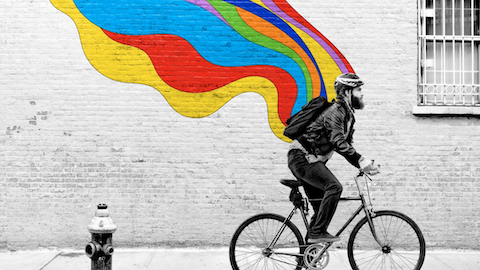

In [161]:
Image('images/cover_image_1.jpg')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Basic-Dataset-Info" data-toc-modified-id="Basic-Dataset-Info-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic Dataset Info</a></span></li><li><span><a href="#Customers-Demography" data-toc-modified-id="Customers-Demography-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Customers Demography</a></span></li><li><span><a href="#Geoloc-Data-Preparation" data-toc-modified-id="Geoloc-Data-Preparation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Geoloc Data Preparation</a></span></li><li><span><a href="#General-Stations-Popularity" data-toc-modified-id="General-Stations-Popularity-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>General Stations Popularity</a></span></li><li><span><a href="#General-Stations-Popularity---Google-Maps-Heatmap" data-toc-modified-id="General-Stations-Popularity---Google-Maps-Heatmap-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>General Stations Popularity - Google Maps Heatmap</a></span></li><li><span><a href="#General-Areas-Popularity---Geohash-Based" data-toc-modified-id="General-Areas-Popularity---Geohash-Based-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>General Areas Popularity - Geohash Based</a></span></li><li><span><a href="#Areas-Poupularity----Year-of-Birth" data-toc-modified-id="Areas-Poupularity----Year-of-Birth-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Areas Poupularity -  Year of Birth</a></span></li><li><span><a href="#Areas-Popularity---Gender" data-toc-modified-id="Areas-Popularity---Gender-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Areas Popularity - Gender</a></span></li><li><span><a href="#Areas-Popularity---User-Type" data-toc-modified-id="Areas-Popularity---User-Type-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Areas Popularity - User Type</a></span></li><li><span><a href="#Areas-Popularity---Month" data-toc-modified-id="Areas-Popularity---Month-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Areas Popularity - Month</a></span></li><li><span><a href="#Areas-Popularity---Weekday" data-toc-modified-id="Areas-Popularity---Weekday-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Areas Popularity - Weekday</a></span></li><li><span><a href="#Areas-Popularity---Time-of-Day" data-toc-modified-id="Areas-Popularity---Time-of-Day-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Areas Popularity - Time of Day</a></span></li><li><span><a href="#Most-Popular-Rides" data-toc-modified-id="Most-Popular-Rides-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Most Popular Rides</a></span></li><li><span><a href="#Long-Ride-Popular-Stations-vs-General-Stations-Popularity" data-toc-modified-id="Long-Ride-Popular-Stations-vs-General-Stations-Popularity-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Long Ride Popular Stations vs General Stations Popularity</a></span></li><li><span><a href="#Final-Thoughts" data-toc-modified-id="Final-Thoughts-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Final Thoughts</a></span></li></ul></div>

## Initialization

In [1]:
# %load ../../projects/misc/utils/import.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime

import os
import pickle

from gmplot import gmplot
from IPython.core.display import display, HTML
from IPython.display import IFrame, Image

from geolib import geohash
import plotly.express as px

import geopandas
from geopandas import GeoDataFrame
import shapely.geometry
from shapely.geometry import Point, Polygon

#from PIL import Image
import contextily as ctx

import ipywidgets as widgets
from ipywidgets import interact

import imageio

#Display Settings
pw = 12
ph = 8
matplotlib.rcParams['figure.figsize'] = (pw, ph)

#Pandas Dsiplay
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

# import warnings
# warnings.filterwarnings('ignore')

token_loc = '../my.mapbox_token'
px.set_mapbox_access_token(open(token_loc).read())

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
#Constants
input_dir = '../inputs/'
output_dir = './outputs/'

newyork_loc = {'latitude':'40.736441', 'longitude':'-73.982091'}

#Usertype map
usertype_map = {'Unknown': 0,
                'Subscriber': 1,
                'Customer': 2}

inv_usertype_map = {v: k for k, v in usertype_map.items()}

#Gender map
gender_map = {'unknown': 0,
              'female': 1,
              'male': 2}

inv_gender_map = {v: k for k, v in gender_map.items()}

#Num days
num_days = 1795

#Display Settings
pw = 12
ph = 8
matplotlib.rcParams['figure.figsize'] = (pw, ph)

#Google API token
gcp_token = open('../gcp-api.token').read()

In [4]:
#Colors
aqua = '#5cd1e0'
peach = '#f2b75e'
blue = '#4cbcf5'
pink = '#ff75c1'
gray = '#adadad'
coral = '#ff6370'
plum = '#c362e3'

In [ ]:
#Load trips data
file_names = [f for f in os.listdir(input_dir) if 'trip' in f]

df = pd.read_csv(input_dir + file_names[0])
for fn in file_names:
    print(fn)
    tdf = pd.read_csv(input_dir + fn)
    #Concat df
    df = pd.concat([df, tdf])
    
#Remove 1st column
df = df[df.columns[1:]]

In [5]:
#Convert to date-time
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

#Sort by start date
df = df.sort_values('starttime')

In [6]:
#Reverse mapping
df['usertype'] = df['usertype'].map(inv_usertype_map)
df['gender'] = df['gender'].map(inv_gender_map)

In [5]:
#Serialize and dump to HDD to reduce load time
dump_loc = '../df.p'

#Save
#pickle.dump(df, open( dump_loc, "wb" ))

#Load
df = pickle.load(open(dump_loc, "rb" ))

## Basic Dataset Info

In [31]:
#Number of rides
print('Number of rides: {:,}'.format(len(df)))

Number of rides: 58,932,466


In [25]:
#Num days
#num_days = (df['starttime'].max().date() - df['starttime'].min().date()).total_seconds() / (24 * 60 * 60)

In [26]:
#First Last Ride
print('First ride: ', df['starttime'].min().date())
print('Latest ride: ', df['starttime'].max().date())

First ride:  2013-07-01
Latest ride:  2018-05-31


In [27]:
#Seasonal df
df['num_rides'] = 1
df = df.set_index('starttime')

#Resample
ts_df = df.resample('1m')[['num_rides']].sum()

#Trend and Season
ts_df['trend'] = ts_df[['num_rides']].rolling(12).mean()
#ts_df['residual'] = ts_df['num_rides'] - ts_df['trend']

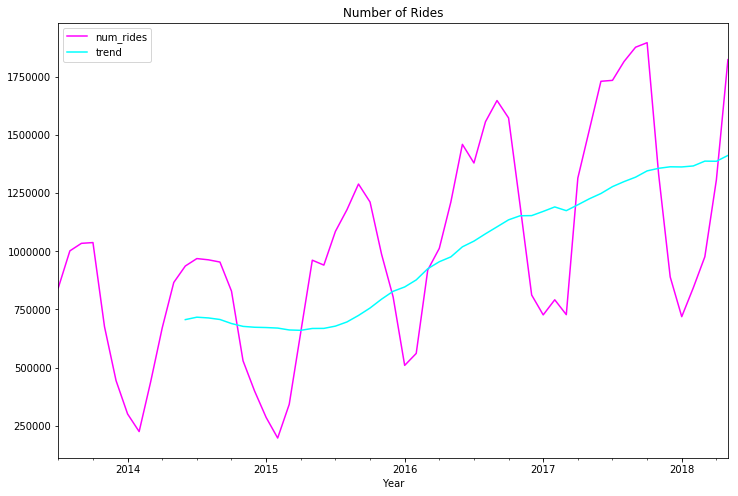

In [28]:
#Plot
ax = ts_df.plot(colormap='cool_r');

ax.set_title('Number of Rides');
ax.set_xlabel('Year');

- We can observe general **increase** in bike rentals 

## Customers Demography

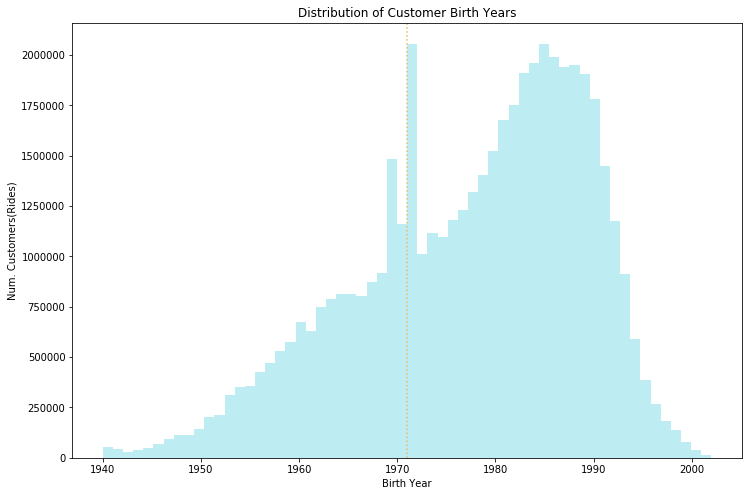

In [108]:
#Plot birth year dist
topl = df[(df['birth_year'].notna()) & (df['birth_year'].between(1940, 2010))]

ax = sns.distplot(topl['birth_year'], bins=60, color=aqua, kde=False)

ax.set_title('Distribution of Customer Birth Years')
ax.set_xlabel('Birth Year')
ax.set_ylabel('Num. Customers(Rides)')
#Draw line
plt.axvline(1971, color=peach, linestyle=':');

- **Most** of the customer are born between **1980 and 1990**.
- There is an **unusually large number** of customers born between **1970 and 1972**.
    - This might be the result of the design of the app interface for customer registration.

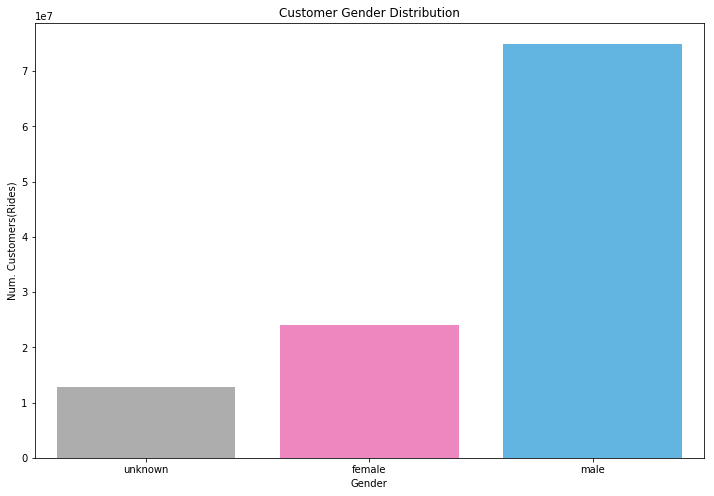

In [10]:
#Plot gender distribution
topl = df

ax = sns.countplot(topl['gender'], palette=[gray, pink, blue])

ax.set_title('Customer Gender Distribution')
ax.set_xlabel('Gender')
ax.set_ylabel('Num. Customers(Rides)');

- There are **almost three times** more male customers than female customers.
- The rides of the male customers should be **subsampled** for **gender bias to be avoided**.

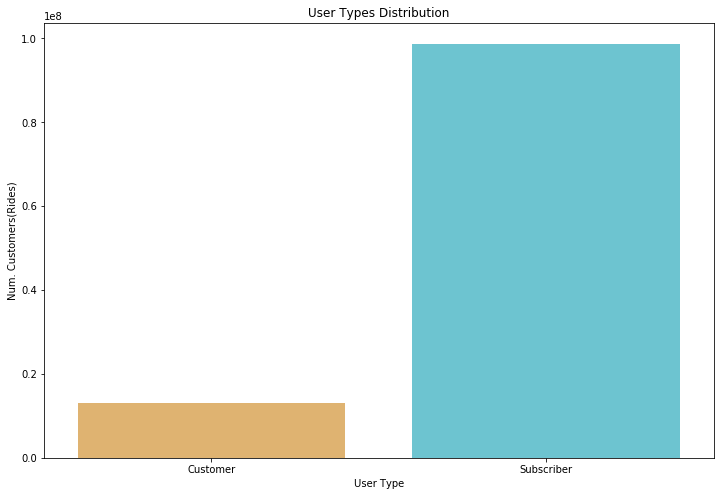

In [21]:
#Plot user type distribution
topl = df

ax = sns.countplot(topl['usertype'], palette=[peach, aqua])

ax.set_title('User Types Distribution')
ax.set_xlabel('User Type')
ax.set_ylabel('Num. Customers(Rides)');

## Geoloc Data Preparation

In [40]:
#Split df to start station/time and end station/time 
#Start
start_columns = ['tripduration', 'starttime', 'start_station_id', 'usertype', 'birth_year', 'gender']
start_renam_dict = {'starttime':'time', 'start_station_id':'station_id'}

start_df = df[start_columns].rename(columns=start_renam_dict)

#End
end_columns = ['tripduration', 'stoptime', 'end_station_id', 'usertype', 'birth_year', 'gender']
end_renam_dict = {'stoptime':'time', 'end_station_id':'station_id'}

end_df = df[end_columns].rename(columns=end_renam_dict)

#Concat
df = pd.concat([start_df, end_df]).sort_values('time')

#Convert to minutes
df['tripduration'] = np.round(df['tripduration'] / 60)

In [43]:
#Add time components
df['year'] =  df['time'].dt.year
df['month'] = df['time'].dt.month
df['weekday'] = df['time'].dt.weekday_name
df['hour'] = df['time'].dt.hour

In [17]:
#Serialize and dump to HDD to reduce load time
dump_loc = '../df_se1.p'

#Save
#pickle.dump(df, open( dump_loc, "wb" ))

#Load
df = pickle.load(open(dump_loc, "rb" ))

In [15]:
#Constants
epsg = 3857
crs = {'init': 'epsg:4326'}

shape_file_loc = '../taxi_zones/'

gh_level = 6

#Boundery Box
long0 = -74.021785
lat0 = 40.660000
long1= -73.820244
lat1 = 40.907992 

boundy_box = Polygon(((long0, lat0), (long1,lat0),  (long1,lat1), (long0, lat1)))

#Week Days
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November',  'December']

#Cutoff lon rides
long_ride_mins = 40

hm_output = output_dir + "ride_stations_heatmap.html"
gif_name_td = './images/time_of_day.gif'
gif_name_month = './images/months.gif'

#Long rides
num_rides = 200
mpr_output = output_dir + "most_popular_ride.html"

In [8]:
#Functions

#Find location polygon
def get_polygon(ny_gdf, point):
    is_inside = ny_gdf['geometry'].map(lambda x: point.within(x))
    if is_inside.sum() > 0:
        return ny_gdf[is_inside]['geometry'].iloc[0]
    else:
        return None
#Find location ID    
def get_location_id(ny_gdf, point):
    is_inside = ny_gdf['geometry'].map(lambda x: point.within(x))
    if is_inside.sum() > 0:
        return ny_gdf[is_inside]['LocationID'].iloc[0]
    else:
        return None

#Geohash to poly
def geo_hash_to_poly(gh):
    box = geohash.bounds(gh)
    long0 = box[0][1]
    lat0 = box[0][0]
    long1= box[1][1]
    lat1 = box[1][0]
    return Polygon(((long0, lat0), (long1,lat0),  (long1,lat1), (long0, lat1)))

#Add basemap
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
#Group by geohash
def group_by_geohash(stations_all):
    #Group geohash
    gr_sta = stations_all.groupby('geohash').agg({'box':'first', 'num_used':'sum'})
    
    #Per day
    gr_sta['num_used'] /= num_days

    #To GeoDF
    gr_sta = GeoDataFrame(gr_sta, crs=crs).set_geometry('box').to_crs(epsg=epsg)
    return gr_sta

#Generate gif
def gen_gif(in_dir, in_name, out_loc):
    images = []
    #imageio.help(name='gif')

    #Filenames
    filenames = [f for f in os.listdir(in_dir) if in_name in f]
    filenames.sort()

    gif_output = out_loc

    for filename in filenames:
        images.append(imageio.imread(in_dir + filename))


    imageio.mimsave(gif_output, images,  duration=0.3, fps=1)

In [9]:
#Prepare stations map
sm = pd.read_csv(input_dir + "/stations_id_map.csv")

#Remove 1st column
sm = sm[sm.columns[1:]]

#Rename columns
old_names = ['start_station_id', 'start_station_name', 'count',
             'start_station_latitude', 'start_station_longitude']

new_names = ['station_id', 'station_name', 'count',
             'latitude', 'longitude']

sm = sm.rename(columns = dict(zip(old_names, new_names)))

#Remove lat=0 or long=0
sm = sm[(sm['latitude'] != 0) & (sm['longitude'] != 0)]
#Filter outliers
sm = sm[sm['latitude'] < 40.85]

#Create Geopandas station map
#Read shapefile
ny_gdf = GeoDataFrame.from_file(shape_file_loc).to_crs(crs)

#Select within boudary box
ny_gdf = ny_gdf[ny_gdf['geometry'].map(lambda x: x.within(boundy_box))]

#Create station map points
geometry = [Point(x) for x in zip(sm['longitude'], sm['latitude'])]

# Creating a Geographic data frame 
sm_gdf = GeoDataFrame(sm, crs=crs, geometry=geometry)

#Add plygon and location id
sm_gdf['polygon'] = sm_gdf['geometry'].map(lambda x: get_polygon(ny_gdf, x));

sm_gdf['LocationID'] = sm_gdf['geometry'].map(lambda x: get_location_id(ny_gdf, x));

#Filter out 'no_id'
sm_gdf = sm_gdf[sm_gdf['polygon'].notna()]

#Add geohash + boxes
#Add geohash
sm_gdf['geohash'] = sm_gdf.apply(lambda x: geohash.encode(x['latitude'], x['longitude'], gh_level), axis=1)

sm_gdf['box'] = sm_gdf['geohash'].map(geo_hash_to_poly)

In [ ]:
#Most popular stations
stations_all = df['station_id'].value_counts()

rename_dict = {'index':'station_id', 'station_id':'num_used'}
stations_all = pd.DataFrame(stations_all).reset_index().rename(columns=rename_dict)

#Add station details
stations_all = pd.merge(stations_all, sm_gdf, on='station_id')

#Per day
stations_all['num_used'] /= num_days

## General Stations Popularity

In [11]:
#Serialize and dump to HDD to reduce load time
dump_loc = '../stations_all.p'

#Save
#pickle.dump(stations_all, open( dump_loc, "wb" ))

#Load
stations_all = pickle.load(open(dump_loc, "rb" ))

In [12]:
#Plot stations
topl = stations_all
fig = px.scatter_mapbox(topl, lat="latitude", lon="longitude", size_max=14,
                        color ='num_used', size='num_used', zoom=11)
fig.show()

## General Stations Popularity - Google Maps Heatmap

In [38]:
#Sample data
to_sample = 100000
sample = df.sample(to_sample, random_state=99)

#Add station details
sample = pd.merge(sample, sm, on='station_id')

In [39]:
# #Jitter
# scale = 0.00006
# x = np.random.randn(len(sample)) * scale
# y = np.random.randn(len(sample)) * scale

# sample['latitude'] += x
# sample['longitude'] += y

In [40]:
#Create gmplot
gmap = gmplot.GoogleMapPlotter(newyork_loc['latitude'], newyork_loc['longitude'], zoom=12, apikey=gcp_token);

#Plot heatmap
gmap.heatmap(sample['latitude'], sample['longitude'], radius=15)

gmap.draw(hm_output)

In [12]:
#Display Map
IFrame(src=hm_output, width=700, height=500)

## General Areas Popularity - Geohash Based

In [309]:
#Group by geohash
gr_sta = group_by_geohash(stations_all)

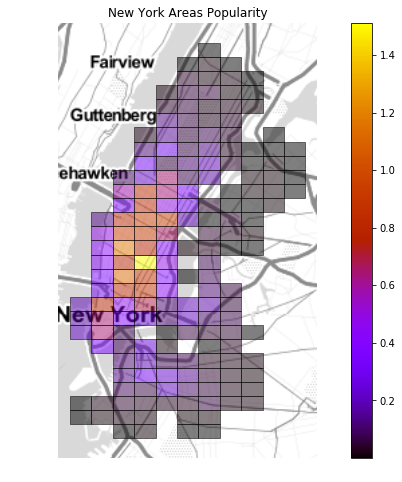

In [310]:
#Plot map
ax = gr_sta.plot(edgecolor='black', column='num_used', legend=True, cmap='gnuplot', alpha=0.5);

ax.set_title('New York Areas Popularity');
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)
ax.set_axis_off()

## Areas Poupularity -  Year of Birth

In [11]:
#Stratify by year of birth
p33, p66 = np.percentile(df['birth_year'].dropna(), 33.33) , np.percentile(df['birth_year'].dropna(), 66.66)

#Fix double names
df.columns = ['tripduration', 'time', 'station_id', 'usertype', 'birth_year', 'gender', 'birth_year1', 'month', 'weekday', 'hour']

#Drop na
df = df.dropna(subset=['birth_year'])

#Year of birth cat
cats = ['.-1973','1973-1984', '1984-.']

df['by_cat'] = df['birth_year'].map(lambda x: cats[0] if x<p33 else cats[1] if x<p66 else cats[2])

In [12]:
#Most popular stations
strat = 'by_cat'
df['num_used'] = 1

stations_age = df.groupby(['station_id', strat], as_index=False)\
                [['num_used']].count()

#Add station details
stations_age = pd.merge(stations_age, sm_gdf, on='station_id')

In [13]:
#Group by geohash
gr_satl = group_by_geohash(stations_age[stations_age[strat] == cats[0]])
gr_satm = group_by_geohash(stations_age[stations_age[strat] == cats[1]])
gr_sath = group_by_geohash(stations_age[stations_age[strat] == cats[2]])

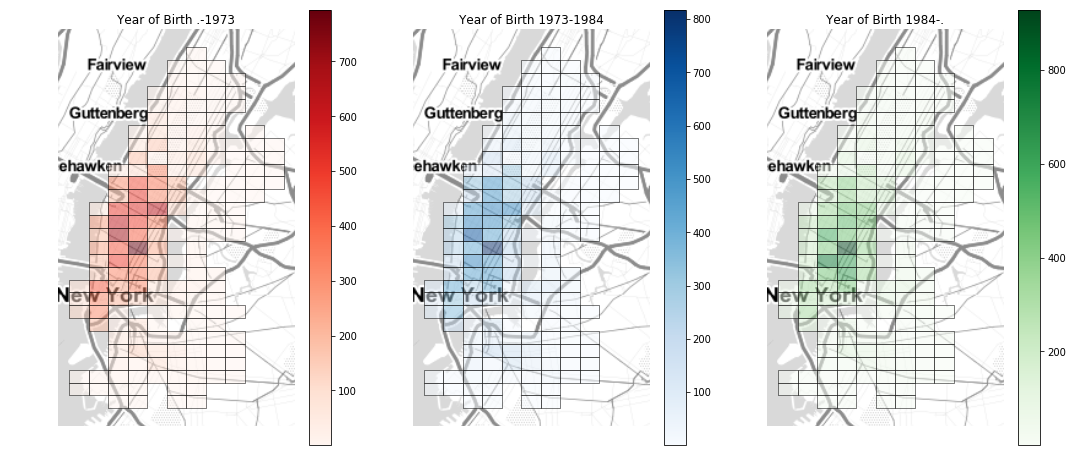

In [14]:
#Plot map
f,ax = plt.subplots(1,3, figsize=(1.5* pw, ph))
#Low
gr_satl.plot(edgecolor='black', column='num_used', legend=True, cmap='Reds', alpha=0.5, ax=ax[0]);

ax[0].set_title('Year of Birth ' + cats[0]);
add_basemap(ax[0], zoom=11, url=ctx.sources.ST_TONER_LITE)
ax[0].set_axis_off()
#Mid
gr_satm.plot(edgecolor='black', column='num_used', legend=True, cmap='Blues', alpha=0.5, ax=ax[1]);

ax[1].set_title('Year of Birth ' + cats[1]);
add_basemap(ax[1], zoom=11, url=ctx.sources.ST_TONER_LITE)
ax[1].set_axis_off()
#Highh
gr_sath.plot(edgecolor='black', column='num_used', legend=True, cmap='Greens', alpha=0.5, ax=ax[2]);

ax[2].set_title('Year of Birth ' + cats[2]);
add_basemap(ax[2], zoom=11, url=ctx.sources.ST_TONER_LITE)
ax[2].set_axis_off()

## Areas Popularity - Gender 

In [311]:
#Most popular stations
strat = 'gender'
df['num_used'] = 1

stations_fm = df.groupby(['station_id', strat], as_index=False)\
                [['num_used']].count()

#Add station details
stations_fm = pd.merge(stations_fm, sm_gdf, on='station_id')

In [312]:
#Group by geohash
gr_satf = group_by_geohash(stations_fm[stations_fm[strat] == 'female'])
gr_satm = group_by_geohash(stations_fm[stations_fm[strat] == 'male'])

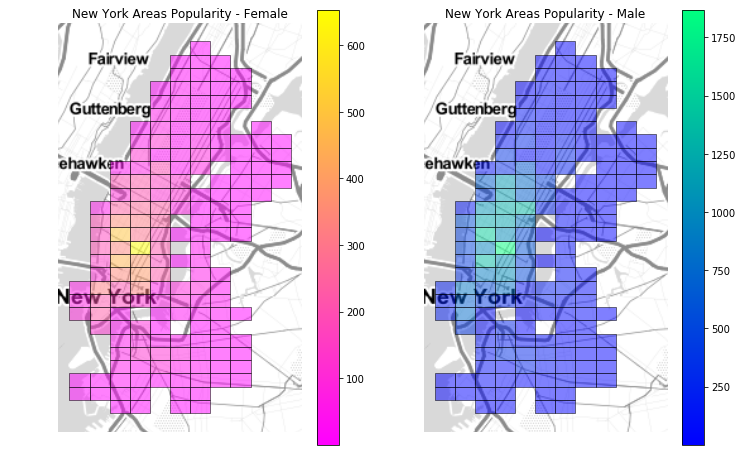

In [313]:
#Plot map
f,ax = plt.subplots(1,2)
#Female
gr_satf.plot(edgecolor='black', column='num_used', legend=True, cmap='spring', alpha=0.5, ax=ax[0]);

ax[0].set_title('New York Areas Popularity - Female');
add_basemap(ax[0], zoom=11, url=ctx.sources.ST_TONER_LITE)
ax[0].set_axis_off()
#Male
gr_satm.plot(edgecolor='black', column='num_used', legend=True, cmap='winter', alpha=0.5, ax=ax[1]);

ax[1].set_title('New York Areas Popularity - Male');
add_basemap(ax[1], zoom=11, url=ctx.sources.ST_TONER_LITE)
ax[1].set_axis_off()

- There are **no noticeable** differences between **female** and **male** users bike usage patterns.

## Areas Popularity - User Type

In [314]:
#Most popular stations
strat = 'usertype'
df['num_used'] = 1

stations_cs = df.groupby(['station_id', strat], as_index=False)\
                [['num_used']].count()

#Add station details
stations_cs = pd.merge(stations_cs, sm_gdf, on='station_id')

In [315]:
#Group by geohash
gr_satc = group_by_geohash(stations_cs[stations_cs[strat] == 'Customer'])
gr_sats = group_by_geohash(stations_cs[stations_cs[strat] == 'Subscriber'])

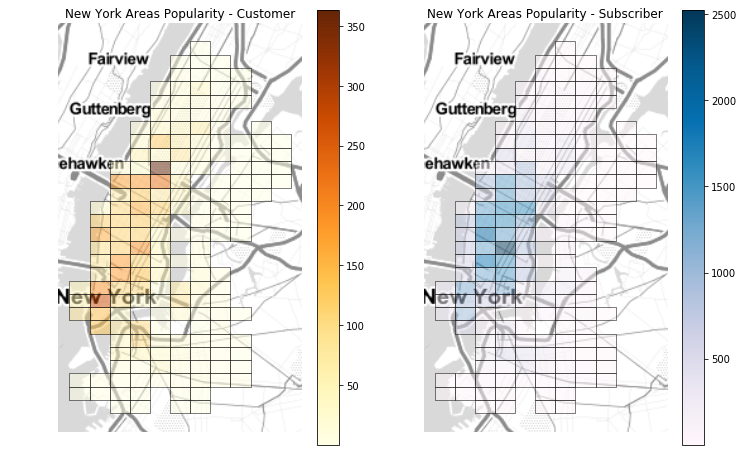

In [316]:
#Plot map
f,ax = plt.subplots(1,2)
#Customer
gr_satc.plot(edgecolor='black', column='num_used', legend=True, cmap='YlOrBr', alpha=0.5, ax=ax[0]);

ax[0].set_title('New York Areas Popularity - Customer');
add_basemap(ax[0], zoom=11, url=ctx.sources.ST_TONER_LITE)
ax[0].set_axis_off()
#Subscriber
gr_sats.plot(edgecolor='black', column='num_used', legend=True, cmap='PuBu', alpha=0.5, ax=ax[1]);

ax[1].set_title('New York Areas Popularity - Subscriber');
add_basemap(ax[1], zoom=11, url=ctx.sources.ST_TONER_LITE)
ax[1].set_axis_off()

- **Customers** (one time users) tend to rent bikes near **Central Park and Hudson River bank** 
    - **Tourists** fall into this category
- **Subscribers** generally visit **central parts of Manhattan**

## Areas Popularity - Month

In [6]:
#Seasonal df - for monthly weekday and hours plots
df['num_rides'] = 1
df = df.set_index('starttime')

In [14]:
#Per Month
#Resample
ts_df = df.resample('1m')[['num_rides']].sum()
ts_df = ts_df.reset_index()

ts_df['month'] = ts_df['starttime'].dt.month_name()

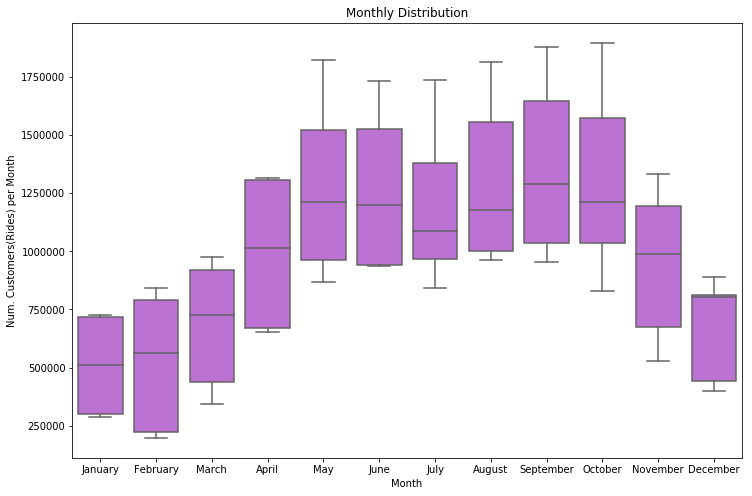

In [17]:
#Monthly dist
topl = ts_df
ax = sns.boxplot(x='month', y='num_rides', order=month_names, data=topl, color=plum)

ax.set_title('Monthly Distribution')
ax.set_xlabel('Month')
ax.set_ylabel('Num. Customers(Rides) per Month');

In [34]:
#Most popular stations
strat = 'month'
df['num_used'] = 1

stations_m = df.groupby(['station_id', strat], as_index=False)\
                [['num_used']].count()

#Add station details
stations_m = pd.merge(stations_m, sm_gdf, on='station_id')

In [35]:
#Group by geohash
gr_satm = group_by_geohash(stations_m)

In [24]:
# #Gen gif  
# #Find vmax
# vmax = 0
# for month in range(1,13):
#     gr_satm = group_by_geohash(stations_m[stations_m[strat] == month])
#     t = gr_satm['num_used'].max()
#     vmax = max(vmax, t)

# #Generate Images
# for month in range(1,13):
#     #Group by geohash
#     gr_satm = group_by_geohash(stations_m[stations_m[strat] == month])
    
#     #Plot map
#     ax = gr_satm.plot(edgecolor='black', column='num_used', legend=True, cmap='gnuplot', alpha=0.8, vmax=vmax);

#     ax.set_title('Month {}'.format(month))
#     add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)
#     ax.set_axis_off()
#     plt.savefig('../gif_images/month_{:02d}.png'.format(month))
#     plt.close()
    
# #Generate gif
# gen_gif('../gif_images/', 'month', gif_name)

In [23]:
# #Display gif
# Image(url=gif_name_month)

In [18]:
#Serialize and dump to HDD to reduce load time
dump_loc = '../stations_m.p'

#Save
#pickle.dump(stations_m, open( dump_loc, "wb" ))

#Load
stations_m = pickle.load(open(dump_loc, "rb" ))

In [19]:
@interact(Month=(1,12,1))

def plot_time(Month=0):
    #Group by geohash
    strat = 'month'
    gr_satm = group_by_geohash(stations_m[stations_m[strat] == Month])
    gr_satm['num_used'] *= 12
    
    #Plot map
    ax = gr_satm.plot(edgecolor='black', column='num_used', legend=True, cmap='gnuplot', alpha=0.8);

    ax.set_title('New York Areas Popularity - Month');
    add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)
    ax.set_axis_off()

interactive(children=(IntSlider(value=1, description='Month', max=12, min=1), Output()), _dom_classes=('widget…

## Areas Popularity - Weekday 

In [21]:
#Per weekday
#Resample
ts_df = df.resample('1d')[['num_rides']].sum()
ts_df = ts_df.reset_index()

ts_df['weekday'] = ts_df['starttime'].dt.weekday_name

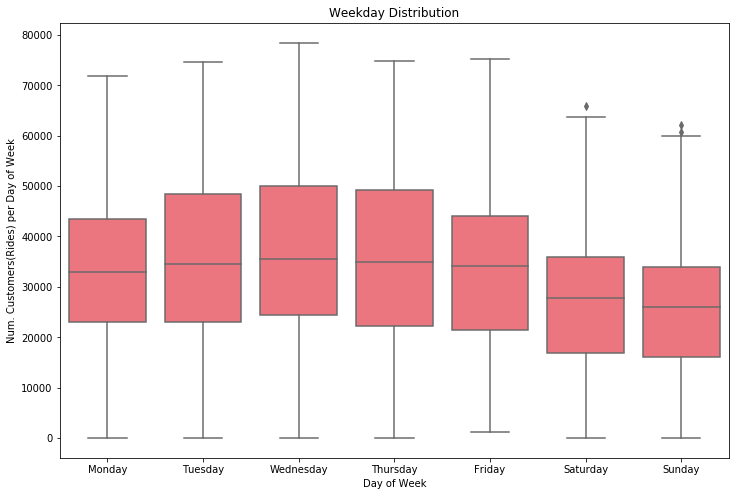

In [24]:
#Weekday dist
topl = ts_df
ax = sns.boxplot(x='weekday', y='num_rides', order=week_days, data=topl, color=coral)

ax.set_title('Weekday Distribution')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Num. Customers(Rides) per Day of Week');

In [38]:
#Most popular stations
strat = 'weekday'
df['num_used'] = 1

stations_wd = df.groupby(['station_id', strat], as_index=False)\
                [['num_used']].count()

#Add station details
stations_wd = pd.merge(stations_wd, sm_gdf, on='station_id')

In [39]:
#Group by geohash
gr_satwd = group_by_geohash(stations_wd)

In [25]:
#Serialize and dump to HDD to reduce load time
dump_loc = '../stations_wd.p'

#Save
#pickle.dump(stations_wd, open( dump_loc, "wb" ))

#Load
stations_wd = pickle.load(open(dump_loc, "rb" ))

In [26]:
@interact(Weekday=(week_days))

def plot_time(Weekday=week_days[0]):
    strat = 'weekday'
    #Group by geohash
    gr_satwd = group_by_geohash(stations_wd[stations_wd[strat] == Weekday])
    gr_satwd['num_used'] *= 1
    
    #Plot map
    ax = gr_satwd.plot(edgecolor='black', column='num_used', legend=True, cmap='PuRd', alpha=0.8);

    ax.set_title('New York Areas Popularity - Weekday');
    add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)
    ax.set_axis_off()

interactive(children=(Dropdown(description='Weekday', options=('Monday', 'Tuesday', 'Wednesday', 'Thursday', '…

- **Weekends** and **Business Days** have different distributions

## Areas Popularity - Time of Day

In [9]:
#Per hour
#Resample
ts_df = df.resample('1h')[['num_rides']].sum()
ts_df = ts_df.reset_index()

ts_df['hour'] = ts_df['starttime'].dt.hour
ts_df['weekday'] = ts_df['starttime'].dt.weekday_name

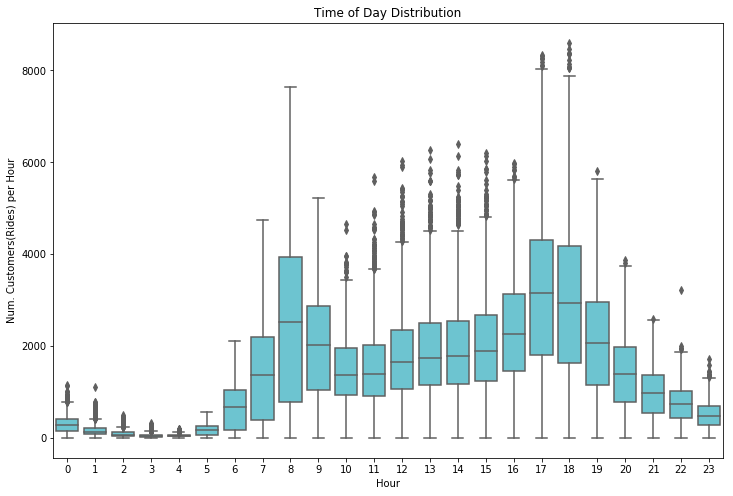

In [29]:
#Time of day dist
topl = ts_df
ax = sns.boxplot(x='hour', y='num_rides', order=range(24), data=topl, color=aqua)

ax.set_title('Time of Day Distribution')
ax.set_xlabel('Hour')
ax.set_ylabel('Num. Customers(Rides) per Hour');

In [43]:
#Most popular stations
strat = 'hour'
df['num_used'] = 1

stations_td = df.groupby(['station_id', strat], as_index=False)\
                [['num_used']].count()

#Add station details
stations_td = pd.merge(stations_td, sm_gdf, on='station_id')

In [26]:
#Group by geohash
gr_sattd = group_by_geohash(stations_td)

In [44]:
#Find vmax
vmax = 0
for hour in range(24):
    gr_sattd = group_by_geohash(stations_td[stations_td[strat] == hour])
    t = gr_sattd['num_used'].max()
    vmax = max(vmax, t)

In [ ]:
#Generate Images
for Hour in range(0,24):
    #Group by geohash
    gr_sattd = group_by_geohash(stations_td[stations_td[strat] == Hour])
    
    #Plot map
    ax = gr_sattd.plot(edgecolor='black', column='num_used', legend=True, cmap='cool', alpha=0.8, vmax=vmax);

    ax.set_title('Hour {}'.format(Hour))
    add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)
    ax.set_axis_off()
    plt.savefig('../gif_images/tod_{:02d}.png'.format(Hour))
    plt.close()

In [46]:
#Generate gif
gen_gif('../gif_images/', 'tod', gif_name_td)

In [18]:
#Display gif
Image(url=gif_name_td)

In [28]:
#Hour/weekdayname
hw = ts_df.groupby(['hour','weekday'], as_index=False)[['num_rides']].sum()
#Prepare hm
hw = hw.pivot_table(index='weekday', columns='hour', values='num_rides', aggfunc='sum').T[week_days]
#Normalize
hw = hw / hw.sum()
hw = hw.T

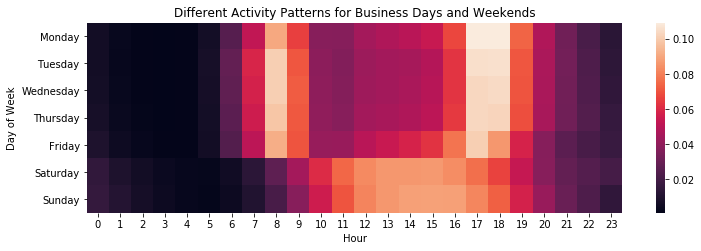

In [35]:
#Plot heatmap
plt.figure(figsize=(pw, pw/24*7));

ax = sns.heatmap(hw);

ax.set_title('Different Activity Patterns for Business Days and Weekends')
ax.set_xlabel('Hour')
ax.set_ylabel('Day of Week');

## Most Popular Rides

In [132]:
#Most popular rides
df['station_id1'] = np.minimum(df['start_station_id'].values, df['end_station_id'].values)
df['station_id2'] = np.maximum(df['start_station_id'].values, df['end_station_id'].values)

#Group by id1 id2
mpr = df.groupby(['station_id1', 'station_id2'])[['start_station_id']].count()\
        .rename(columns={'start_station_id':'num_used'})
#Sort
mpr.sort_values('num_used', ascending=False, inplace=True)

#Select top
mpr = mpr[:num_rides].reset_index()

#Add station details
mpr = pd.merge(mpr, sm, left_on='station_id1' ,right_on='station_id')
mpr = pd.merge(mpr, sm, left_on='station_id2' ,right_on='station_id')

In [149]:
#Create gmplot
gmap = gmplot.GoogleMapPlotter(newyork_loc['latitude'], newyork_loc['longitude'], zoom=12, apikey=gcp_token);

#Plot heatmap
for i in range(0, len(mpr)):
    lats = [mpr['latitude_x'][i], mpr['latitude_y'][i]]
    longs = [mpr['longitude_x'][i], mpr['longitude_y'][i]]
    
    width = 20 * mpr['num_used'][i] / mpr['num_used'][0]
    alpha = 1 * mpr['num_used'][i] / mpr['num_used'][0]
    
    gmap.plot(lats, longs, pink, edge_width=width, edge_alpha=alpha)

gmap.draw(mpr_output)

In [15]:
#Display Map
IFrame(src=mpr_output, width=700, height=500)

## Long Ride Popular Stations vs General Stations Popularity 

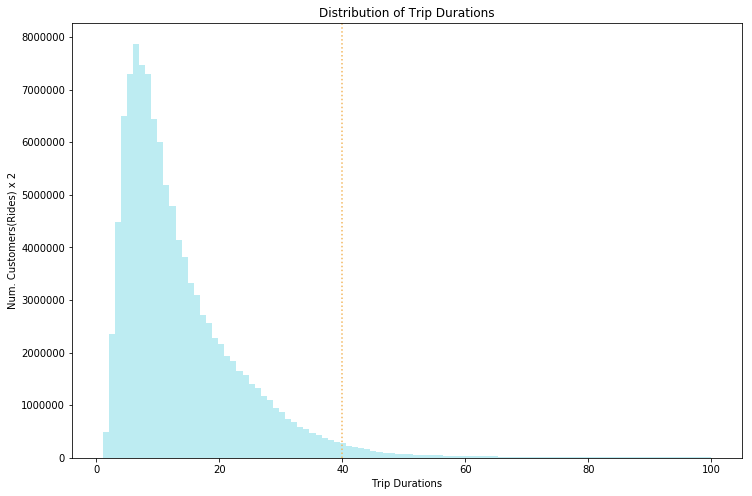

In [19]:
#Plot trip duratons
topl = df[df['tripduration'].between(0, 100)]

ax = sns.distplot(topl['tripduration'], bins=100, color=aqua, kde=False)

ax.set_title('Distribution of Trip Durations')
ax.set_xlabel('Trip Durations')
ax.set_ylabel('Num. Customers(Rides) x 2')
#Draw line
plt.axvline(long_ride_mins, color=peach, linestyle=':');

In [95]:
#Top 10 stations for long rides
nstations_top10_long = 10

stations_top10_long = df[df['tripduration'] > long_ride_mins]['station_id'].value_counts().iloc[:nstations_top10_long]

rename_dict = {'index':'station_id', 'station_id':'num_used'}
stations_top10_long = pd.DataFrame(stations_top10_long).reset_index().rename(columns=rename_dict)

#Add station details
stations_top10_long = pd.merge(stations_top10_long, sm, on='station_id')

In [96]:
#Top 10 stations_top10
nstations_top10 = 10

stations_top10 = df['station_id'].value_counts().iloc[:nstations_top10]

rename_dict = {'index':'station_id', 'station_id':'num_used'}
stations_top10 = pd.DataFrame(stations_top10).reset_index().rename(columns=rename_dict)

#Add station details
stations_top10 = pd.merge(stations_top10, sm, on='station_id')

In [97]:
#Add trip type
stations_top10['Trip Duration'] = 'All'
stations_top10_long['Trip Duration'] = 'Long'

topl = pd.concat([stations_top10, stations_top10_long])

In [16]:
#Serialize and dump to HDD to reduce load time
dump_loc = '../topl.p'

#Save
#pickle.dump(topl, open( dump_loc, "wb" ))

#Load
topl = pickle.load(open(dump_loc, "rb" ))

In [17]:
#Plot stations
fig = px.scatter_mapbox(topl, lat="latitude", lon="longitude", color="Trip Duration", 
                        color_discrete_sequence=[coral, aqua], text='station_name', zoom=11)
fig.show()

In [22]:
#Weekend vs business days
df['Weekend'] = np.logical_or((df['weekday']=='Saturday').values,(df['weekday']=='Sunday').values)

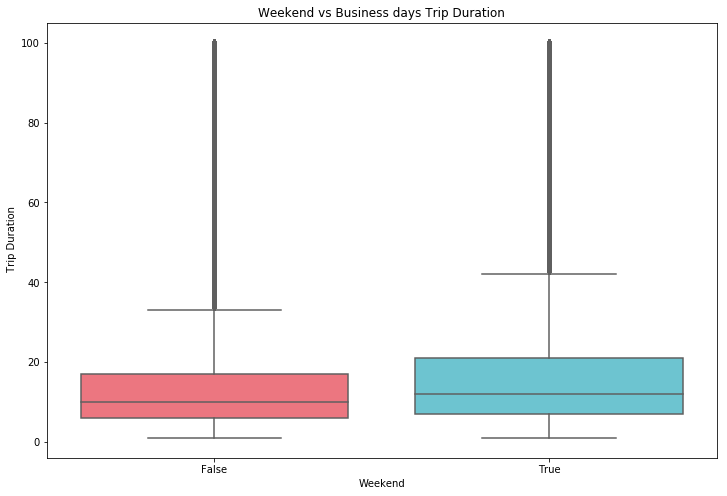

In [31]:
#Plot
topl = df[df['tripduration'].between(0, 100)]

ax = sns.boxplot(x='Weekend', y='tripduration',  data=topl, palette=[coral, aqua])

ax.set_title('Weekend vs Business days Trip Duration')
ax.set_ylabel(' Trip Duration');

## Final Thoughts

- It would be interesting to see how mobility patterns change during **special events** such as:
    - New York City Marathon
    - NYC Pride March
    - New Years Eve
    - Other Holidays
- Analysing just start or stop (instead of combined approach) station might give us new insights
- Adding **the newest Citibike data** might improve the analysis 
- Including **additional data sets** could greatly enrich the research